In [5]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

In [6]:
# Create a toy dataset to work with,  we want each point to have a position in R2 and an orientation
# For example,  let's make the 'force dataset' where each point has a position and an orientation
# And one hidden feature which depends on the positions and an initial value.



In [154]:
def get_base_data(num_points, cov=0.5):
    mu = np.zeros(2)
    sigma = np.array([[1, cov], [cov, 1]])
    locations = np.random.multivariate_normal(
        mu, sigma, size=(num_points)
    )
    x, y = locations[:, 0], locations[:, 1]
    angles = np.random.uniform(0, np.pi * 2, num_points)
    hidden_features = np.random.normal(0, 1, size=num_points)

    return x, y, angles, hidden_features

def get_displacements(xs, ys):
    x_displacement = np.subtract.outer(xs, xs)
    y_displacement = np.subtract.outer(ys, ys)

    displacement_vectors = np.dstack((x_displacement, y_displacement))

    return displacement_vectors

def thetas_to_unit_vectors(thetas):
    x, y = np.cos(thetas), np.sin(thetas)
    return np.column_stack((x, y))

def compute_angular_components(thetas, displacement_vectors):
    # Define \alpha_ij = (x_i - x_j) @ theta_j
    # Where theta_j is the unit vector pointing in the direction theta
    theta_j = thetas_to_unit_vectors(thetas)

    num_points = thetas.shape[0]
    alphas = np.zeros(shape=(num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            alphas[i, j] = displacement_vectors[i, j] @ theta_j[j]

    return alphas

def compute_targets(hidden, angular_components):
    return angular_components@hidden

def compute_targets_from_base_data(x, y, angles, hidden_features):
    displacement = get_displacements(x, y)
    alpha = compute_angular_components(angles, displacement)
    output_forces = compute_targets(hidden_features, angular_components=alpha)

    return output_forces

def rotate_base_data(x, y, angles, hidden_features, r_theta):
    loc_matrix = np.row_stack((x, y))
    c, s =np.cos(r_theta), np.sin(r_theta)
    rotation_matrix = np.array([[c, s],[-s, c]]) # anticlockwise rotation
    out_loc = rotation_matrix @ loc_matrix
    out_x, out_y = out_loc[0, :], out_loc[1, :]

    out_angles = angles + r_theta % (np.pi*2)
    return out_x, out_y, out_angles, hidden_features

def translate_base_data(x , y, angles, hidden_features, translation_x, translation_y):
    tx, ty = x + translation_x, y + translation_y
    return tx, ty, angles, hidden_features


def make_one_graph(num_points=120, rot=None, translation=None):
    assert not (rot and translation) # TODO hack - need to make these affine transformations somehow?
    x, y, theta, h = get_base_data(num_points, cov=0.5)

    if rot:
        x, y, theta, h = rotate_base_data(x, y, theta, h, rot)
    if translation:
        x, y, theta, h = translate_base_data(x, y, theta, h, rot)

    output_forces = compute_targets_from_base_data(x, y, theta, h)

    data = {'x': x, 'y': y, 'theta': theta, 'h': h, 'output_forces': output_forces}
    df = pd.DataFrame(data=data)
    df = df.reset_index().rename(columns={'index': 'vertex_id'})

    return df


In [155]:
### Testing for what is above

num_points = 500
x, y, theta, h = get_base_data(num_points, cov=0.5)
displacement = get_displacements(x, y)

# A quick test to make sure the indexing has turned out as expected for the displacement.
test_disp = np.array([x[0]-x[1], y[0] - y[1]])
assert np.allclose(displacement[0, 1, :], test_disp)

alpha = compute_angular_components(theta, displacement)
out = compute_targets(h, alpha)

delta = np.pi/4
rx, ry, rtheta, rh = rotate_base_data(x, y, theta, h, delta)

# Do a quick test to check that the rotated unit vectors are as expected
u, ru = thetas_to_unit_vectors(theta), thetas_to_unit_vectors(rtheta)
test_u = np.zeros(u.shape[0])
for i in range(test_u.shape[0]):
    test_u[i] = u[i, :] @ ru[i, :]
assert np.allclose(np.arccos(test_u), delta)

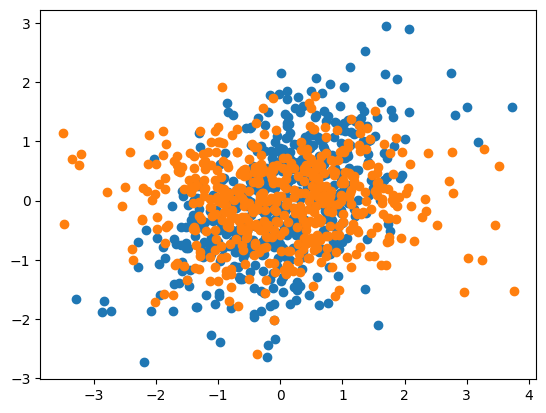

In [156]:
plt.scatter(x, y)
plt.scatter(rx, ry)

In [157]:
def make_dataset(num_graphs, num_points=500):
    frames = []
    for n in range(num_graphs):
        data = make_one_graph(num_points)

        df = pd.DataFrame(data)
        df['graph_id'] = n
        frames.append(df)
    return pd.concat(frames)

In [158]:
dataset = make_dataset(30, 120)

In [159]:
dataset

,vertex_id,x,y,theta,h,output_forces,graph_id
0,0,-0.352040,0.314830,2.247790,-0.728275,13.681369,0
1,1,0.305227,0.346749,3.887715,1.032635,9.548720,0
2,2,-0.067478,0.114825,0.772388,0.735329,9.530188,0
3,3,0.740389,-0.170467,0.593732,-0.102318,0.865844,0
4,4,-0.076060,0.602086,0.226319,-0.005528,14.971171,0
...,...,...,...,...,...,...,...
115,115,0.275377,0.268963,1.817869,-1.647849,-6.537313,29
116,116,-0.548488,-0.176949,5.665316,0.109543,-17.166407,29
117,117,-0.197117,-0.030249,1.223409,-0.505139,-12.941546,29
118,118,-2.084800,-1.788116,0.900884,0.458251,-42.516586,29


### Need to give the raw data a steerable representation

In [163]:
class Complex:

    def __init__(self, r, theta):
        assert r >= 0
        self.r = r
        self.theta = theta % (np.pi*2)

    def __repr__(self):
        return f"{self.r}*exp[i {self.theta}]"

    @property
    def euc_form(self):
        # Python natively uses Euclidean form
        return self.r*np.exp(1j*self.theta)

    @property
    def real(self):
        return self.r * np.cos(self.theta)

    @property
    def im(self):
        return self.r * np.sin(self.theta)

    @classmethod
    def from_euc(cls, z):
        r = abs(z)
        theta = np.arctan2(z.imag, z.real)

        return cls(r, theta)

In [190]:
# Do this into complex space - nicer to work with for computing shift properties

def fourier_transform_point_function(z: Complex, precision):
    """Analytically obtain the fourier transform of a dirac function on S1 """
    indexes = np.arange(-precision, precision + 1)
    c = [
        z.r*np.exp(-1j*k*z.theta) for k in indexes # cast to euc form so python can do operations
    ]
    scaler = 1/np.pi
    c = np.array(c) * scaler
    f_hat = np.column_stack((indexes, c))
    return f_hat

def inverse_transform(f_hat):
    k = f_hat[:, 0]
    c = f_hat[:, 1]

    scaler = 1/(2*np.pi)
    components = lambda x: c*np.exp(-k*x*1j)
    f = lambda x: scaler*components(x).sum()
    f = np.vectorize(f)
    return f

C:\Users\niksm\Documents\CodeForUni\venvs\transformer_invariants\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Argument shifted: \n dual domain')

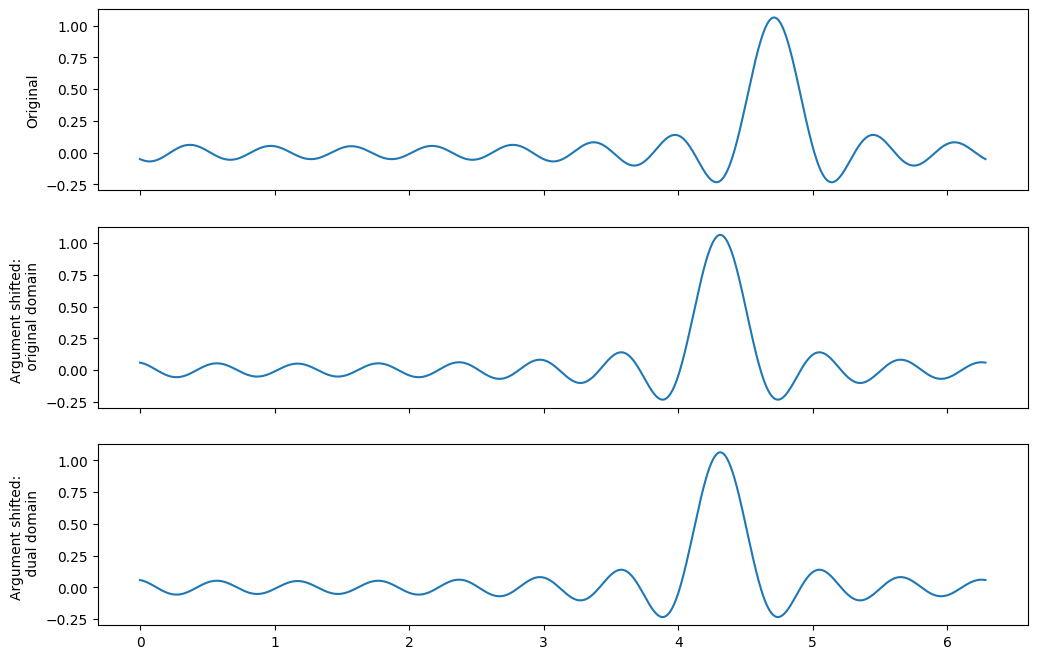

In [191]:
fig, ax = plt.subplots(3, figsize=[12,8], sharex=True)

# adjust the main plot to make room for the sliders
xs = np.linspace(0, 2*np.pi, 1000)
N = 10
m = 4

init_r, init_theta = 1.0, np.pi/2
offset_theta = 1/N*m # shift has to be k-dependent or you are mixing groups

# Plot the original function
z_orig = Complex(init_r, init_theta)
z_hat_orig = fourier_transform_point_function(z_orig, N)
z_hat_hat_orig = inverse_transform(z_hat_orig)

ax[0].plot(xs, z_hat_hat_orig(xs))
ax[0].set_ylabel('Original')

# Perform the shift in the original domain.

z_shift_in = Complex(init_r, init_theta + offset_theta)
z_hat_shift_in = fourier_transform_point_function(z_shift_in, N)
z_hat_hat_in = inverse_transform(z_hat_shift_in)

ax[1].plot(xs, z_hat_hat_in(xs))
ax[1].set_ylabel('Argument shifted: \n original domain')

# Perform the shift in the dual domain.
z_hat_shifted_out = z_hat_orig.copy()
shifter = np.exp(-1j*offset_theta*z_hat_shifted_out[:, 0]) # Where does this 2 come from??
z_hat_shifted_out[:, 1] *= shifter

z_hat_hat_shifted_out = inverse_transform(z_hat_shifted_out)
ax[2].plot(xs, z_hat_hat_shifted_out(xs))
ax[2].set_ylabel('Argument shifted: \n dual domain')

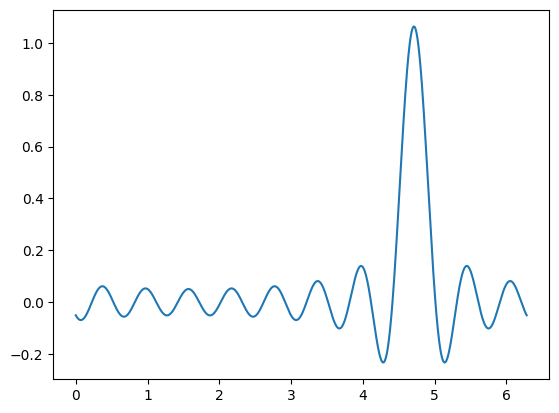

In [185]:
plt.plot(xs, z_hat_hat_orig(xs).real/np.pi)

### Note - haven't quite figured out the radius here!

#### Now define a transformer that works on these

In [16]:
class AttentionBlock(torch.nn.Module):

    def __init__(self):
        super().__init__()

In [ ]:
class Base_SE2_Transformer(torch.nn.Module):
    """An abstract class! Need to subclass to produce invariants """
    def __init__(self, attention_hidden_units):
        super().__init__()

        self.attention_calculator = torch.nn

    def get_num_invariant_dimensions(self):
        raise NotImplementedError("Implement on subclass")

    def forward(self, x, ys):
        raise NotImplementedError() # TODO

    def get_positional_invariants(self, coords_1, coords_2):
        raise NotImplementedError("Create a subclass to implement this!")

class Euclidean_SE2_Transformer(Base_SE2_Transformer):

    def get_positional_invariant(self, coords_1, coords_2):
        x1, y1, theta1 = coords_1
        x2, y2, theta2 = coords_2

        x_diff = x1 - x2
        y_diff = y1 - y2
        return np.sqrt(x_diff**2 + y_diff**2)

    def get_num_invariant_dimensions(self):
        return 1

class FullyExpressive_SE2_Transformer(Base_SE2_Transformer):

    def get_positional_invariants(self, coords_1, coords_2):
        x1, y1, theta1 = coords_1
        x2, y2, theta2 = coords_2

        x_diff = x1 - x2
        y_diff = y1 - y2
        angle_diff = theta2 - theta1
        return np.sqrt(x_diff**2 + y_diff**2), angle_diff


